In [1]:
# ch4/ch4_4_gnn/gat.ipynb
# 标准库
import sys

# 第三方库
import numpy as np
import tqdm
import torch

# 自定义模块
sys.path.append('./../../')
import utils.dataset as d
import utils.metrics as m
import utils.plot as p
from dataset_loader import GraphDatasetLoader
from model import GAT

# 绘图参数
name_model = 'GAT'
name_var = '交通流量'
name_unit = ' (Vehicle)'
p.set_matplotlib(plot_dpi=80, save_dpi=600, font_size=12)


样本数量: 8052
训练样本:6036
测试样本:2016
特征: (307, 1, 12)
标签: (307, 1)
边: (2, 680)
权重: (680,)


,序列长度,最大值,最小值,均值,标准差,偏度,峰度
0,8064,608.0,0.0,236.68,130.29,-0.08,-1.04


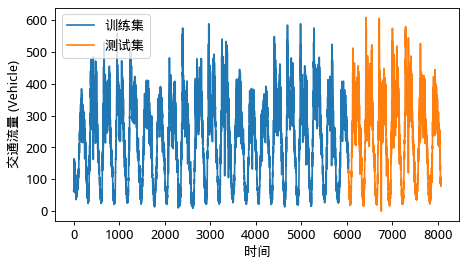

In [2]:
# 数据读取
loader = GraphDatasetLoader(
    data_type='traffic',
    path_data='./data/data_traffic.csv',
    path_graph='./data/graph_traffic.csv'
)

# 创建数据集
H = 12
N = 307
dataset = loader.get_dataset(
    H,
    num_train=7*24*12*3,  # 7天/周 × 24时/天 × 12记录/时 × 3周
    num_test=7*24*12*1  # 7天/周 × 24时/天 × 12记录/时 × 1周
)
train, test = loader.train_test_split(dataset)

# 查看样本信息
print(f'样本数量: {dataset.snapshot_count}')
print(f'训练样本: {train.snapshot_count}')
print(f'测试样本: {test.snapshot_count}')
print(f'特征: {dataset.features[0].shape}')
print(f'标签: {dataset.targets[0].shape}')
print(f'边: {dataset.edge_index.shape}')
print(f'权重: {dataset.edge_weight.shape}')

# 数据集分析和可视化
target_node_id = 0  # 仅关注目标节点(0号节点)
target_series = loader.x[:, target_node_id]
d.stats(target_series)
p.plot_dataset(
    train=target_series[:7*24*12*3-H],
    test=target_series[7*24*12*3-H:],
    xlabel='时间',
    ylabel=f'{name_var}{name_unit}',
    fig_name=f'{name_model}_序列'
)


In [3]:
# 训练设备
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 模型构建
model = GAT(H, num_neurons=32, num_heads=2).to(DEVICE)
# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# 学习率调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=25,
    threshold=1E-3,
    threshold_mode='rel',
    cooldown=30,
    verbose=True)
# 损失函数
loss_func = torch.nn.MSELoss()

# 模型查看
print(model)

# 训练集-训练
num_epoch = 100
loss_train = np.empty(num_epoch)
bar = tqdm.trange(num_epoch, ncols=100)
model.train()
for epoch in bar:

    # 初始化
    bar.set_description(f'Epoch: {epoch+1}')
    loss_epoch = np.empty(train.snapshot_count)
    cost = 0

    # 迭代全部训练样本
    for batch_id, snapshot in enumerate(train):

        # 获取数据
        targets = snapshot.y.to(DEVICE)
        inputs = snapshot.x.to(DEVICE)
        inputs_edge = snapshot.edge_index.to(DEVICE)

        # 前向传播
        outputs = model(inputs, inputs_edge)

        # 损失计算
        loss = loss_func(outputs, targets).to(DEVICE)
        cost += loss

        # 当前批次损失
        loss_epoch[batch_id] = loss.item()

    # 误差反向传播
    cost.backward()

    # 更新模型参数
    optimizer.step()
    optimizer.zero_grad()

    # 训练损失
    loss_train[epoch] = np.mean(loss_epoch)

    # 调度器
    scheduler.step(loss_train[epoch])

    # 更新进度显示
    bar.set_postfix(loss=f'{loss_train[epoch]:.6f}')

# 模型持久化
torch.save(model, './model/gat.pkl')


GAT(
  (conv_1): GATConv(12, 32, heads=2)
  (conv_2): GATConv(64, 32, heads=2)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


Epoch: 100: 100%|██████████████████████████████████| 100/100 [21:59<00:00, 13.20s/it, loss=0.009279]


In [4]:
# 测试集-预测
y_true = np.empty([test.snapshot_count, N])
y_pred = np.empty([test.snapshot_count, N])
model.eval()
with torch.no_grad():

    # 迭代全部测试样本
    for batch_id, snapshot in enumerate(test):

        # 获取数据
        targets = snapshot.y.to(DEVICE)
        inputs = snapshot.x.to(DEVICE)
        inputs_edge = snapshot.edge_index.to(DEVICE)

        # 前向传播
        outputs = model(inputs, inputs_edge)

        # 损失计算
        loss = loss_func(outputs, targets).to(DEVICE)

        # 存储测试集真值和预测值
        y_true[batch_id] = targets.detach().cpu().numpy().squeeze()
        y_pred[batch_id] = outputs.detach().cpu().numpy().squeeze()

# 反归一化
minimum = loader.min
maximum = loader.max
base = maximum-minimum
# [num_test, N]×[N,]+[N,] -> [num_test, N] × [N,]
y_true = y_true*base+minimum
# [num_test, N]×[N,]+[N,] -> [num_test, N] × [N,]
y_pred = y_pred*base+minimum

# 去除异常值
y_pred[np.where(y_pred < 0)] = 0  # 防止出现负交通流量

# 测试集-误差计算
y_ture_target_station = y_true[:, target_node_id]
y_pred_target_station = y_pred[:, target_node_id]
m.all_metrics(y_true=y_ture_target_station, y_pred=y_pred_target_station)


mse=2316.032
rmse=48.125
mae=35.387
mape=105930638.863%
sde=46.672
r2=0.875
pcc=0.939


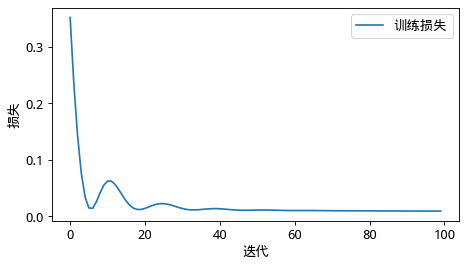

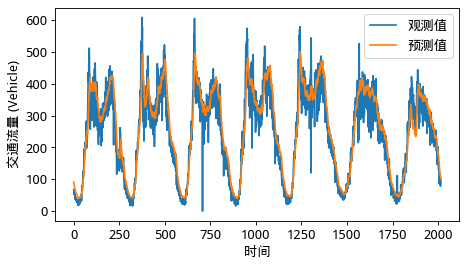

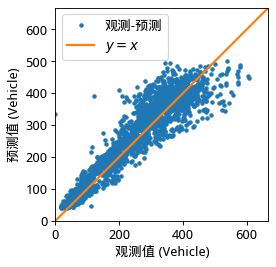

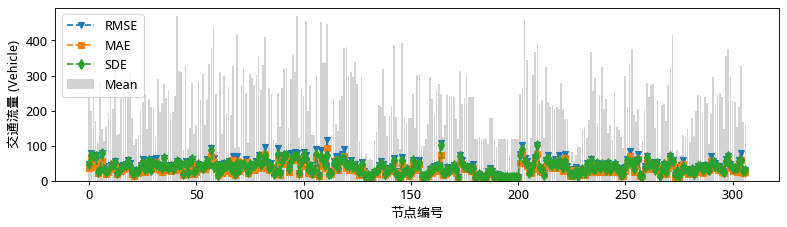

In [5]:
# 可视化
p.plot_losses(
    train_loss=loss_train,
    xlabel='迭代',
    ylabel='损失',
    fig_name=f'{name_model}_损失'
)
p.plot_results(
    y_true=y_ture_target_station,
    y_pred=y_pred_target_station,
    xlabel='时间',
    ylabel=f'{name_var}{name_unit}',
    fig_name=f'{name_model}_预测曲线'
)
p.plot_parity(
    y_true=y_ture_target_station,
    y_pred=y_pred_target_station,
    xlabel=f'观测值{name_unit}',
    ylabel=f'预测值{name_unit}',
    fig_name=f'{name_model}_Parity'
)
p.plot_metrics_distribution(
    y_true=y_true,
    y_pred=y_pred,
    xlabel='节点编号',
    ylabel=f'{name_var}{name_unit}',
    fig_name=f'{name_model}_误差分布'
)
